In [1]:
import numpy as np
import pandas as pd
import keras
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate, Reshape, LSTM, CuDNNLSTM
#from keras.layers import K
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

Using TensorFlow backend.


In [2]:
class1 = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
class2 = {0:'Mononuclear',1:'Polynuclear'}
tree_path = 'C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\BCCD\\Annotations'
image_path = 'C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\BCCD\\JPEGImages'

In [3]:
def get_data(folder, size):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=size)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [4]:
from PIL import Image
size=(64, 64)
X_train, y_train, z_train = get_data('C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\dataset2-master\\images\\TRAIN\\', size)
X_test, y_test, z_test = get_data('C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\dataset2-master\\images\\TEST\\', size)

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:01<00:00, 502.82it/s]


In [5]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

In [6]:
# Normalize to [0,1]
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

# Model M01

In [15]:
#Training Parameters 
batch_size  = 128
epochs      = 200

#Input Data parameters
num_classes = 5
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 3)

#Build Model
model = Sequential() #Keras sequential builder
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Flatten())

model.add(Dense(64, activation='relu')) 
model.add(Dropout(.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#Train Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [ ]:
model.summary()

In [16]:
history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [datagen.standardize(X_test), y_testHot], verbose=2)

Epoch 1/200
 - 9s - loss: 1.4660 - acc: 0.2532 - val_loss: 1.3363 - val_acc: 0.3430
Epoch 2/200
 - 9s - loss: 1.3111 - acc: 0.3516 - val_loss: 1.1244 - val_acc: 0.4447
Epoch 3/200
 - 9s - loss: 1.1888 - acc: 0.4249 - val_loss: 1.0450 - val_acc: 0.4757
Epoch 4/200
 - 9s - loss: 1.1560 - acc: 0.4374 - val_loss: 1.0322 - val_acc: 0.4829
Epoch 5/200
 - 9s - loss: 1.1079 - acc: 0.4473 - val_loss: 1.0228 - val_acc: 0.4910
Epoch 6/200
 - 9s - loss: 1.0808 - acc: 0.4628 - val_loss: 1.0154 - val_acc: 0.5187
Epoch 7/200
 - 9s - loss: 1.0589 - acc: 0.4866 - val_loss: 1.0012 - val_acc: 0.5271
Epoch 8/200
 - 9s - loss: 1.0066 - acc: 0.5266 - val_loss: 0.9532 - val_acc: 0.5501
Epoch 9/200
 - 9s - loss: 0.9535 - acc: 0.5609 - val_loss: 0.9153 - val_acc: 0.5742
Epoch 10/200
 - 9s - loss: 0.8952 - acc: 0.5972 - val_loss: 0.8445 - val_acc: 0.6108
Epoch 11/200
 - 9s - loss: 0.8255 - acc: 0.6287 - val_loss: 0.7787 - val_acc: 0.6526
Epoch 12/200
 - 9s - loss: 0.7638 - acc: 0.6553 - val_loss: 0.7053 - val_a

KeyboardInterrupt: 

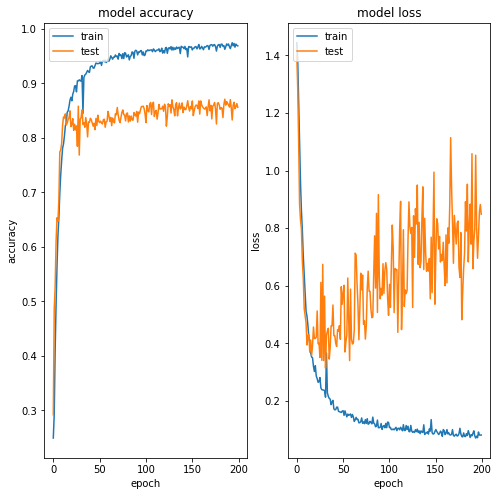

In [9]:
plot_learning_curve(history.history)
plt.show()

# Model M01.5

In this model I do not run feature centering. (Will need to reload data prior to running)

In [11]:
#Training Parameters 
batch_size  = 128
epochs      = 100

#Input Data parameters
num_classes = 5
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 3)

#Build Model
model = Sequential() #Keras sequential builder
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Flatten())

model.add(Dense(64, activation='relu')) 
model.add(Dropout(.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#Train Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
__________

In [21]:
history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Epoch 1/100
 - 9s - loss: 1.4202 - acc: 0.2479 - val_loss: 1.4015 - val_acc: 0.2461
Epoch 2/100
 - 8s - loss: 1.3980 - acc: 0.2576 - val_loss: 1.3986 - val_acc: 0.2505
Epoch 3/100
 - 8s - loss: 1.3952 - acc: 0.2562 - val_loss: 1.3954 - val_acc: 0.2577
Epoch 4/100
 - 8s - loss: 1.3932 - acc: 0.2535 - val_loss: 1.3890 - val_acc: 0.2505
Epoch 5/100
 - 8s - loss: 1.3721 - acc: 0.2956 - val_loss: 1.2944 - val_acc: 0.3406
Epoch 6/100
 - 8s - loss: 1.2951 - acc: 0.3750 - val_loss: 1.1799 - val_acc: 0.4741
Epoch 7/100
 - 8s - loss: 1.2534 - acc: 0.4018 - val_loss: 1.1347 - val_acc: 0.5115
Epoch 8/100
 - 8s - loss: 1.1835 - acc: 0.4524 - val_loss: 1.0751 - val_acc: 0.5123
Epoch 9/100
 - 8s - loss: 1.1360 - acc: 0.4768 - val_loss: 1.0424 - val_acc: 0.5283
Epoch 10/100
 - 8s - loss: 1.1062 - acc: 0.4898 - val_loss: 0.9973 - val_acc: 0.5292
Epoch 11/100
 - 8s - loss: 1.0825 - acc: 0.4982 - val_loss: 1.0038 - val_acc: 0.5328
Epoch 12/100
 - 8s - loss: 1.0549 - acc: 0.5135 - val_loss: 1.0570 - val_a

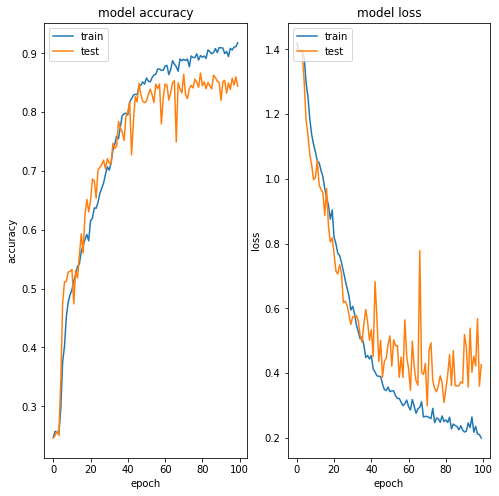

In [22]:
plot_learning_curve(history.history)
plt.show()

# Model M02

Additional layers are added.

In [110]:
from keras import regularizers
#Training Parameters 
batch_size  = 128*2
epochs      = 100

#Input Data parameters
num_classes = 5
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 3)

#Build Model
model = Sequential() #Keras sequential builder
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(num_classes, activation='softmax'))

#Train Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_232 (Conv2D)          (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
flatten_41 (Flatten)         (None, 9216)              0         
__________

In [111]:
history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Epoch 1/100
 - 12s - loss: 1.4246 - acc: 0.2660 - val_loss: 1.3198 - val_acc: 0.4383
Epoch 2/100
 - 8s - loss: 1.2839 - acc: 0.3756 - val_loss: 1.0849 - val_acc: 0.5581
Epoch 3/100
 - 8s - loss: 1.1376 - acc: 0.4695 - val_loss: 1.0955 - val_acc: 0.4901
Epoch 4/100
 - 8s - loss: 0.9645 - acc: 0.5538 - val_loss: 0.8975 - val_acc: 0.5806
Epoch 5/100
 - 8s - loss: 0.8206 - acc: 0.6144 - val_loss: 0.8925 - val_acc: 0.6325
Epoch 6/100
 - 8s - loss: 0.7604 - acc: 0.6414 - val_loss: 0.6702 - val_acc: 0.6916
Epoch 7/100
 - 8s - loss: 0.6422 - acc: 0.6894 - val_loss: 0.6992 - val_acc: 0.7149
Epoch 8/100
 - 8s - loss: 0.6023 - acc: 0.7028 - val_loss: 0.6649 - val_acc: 0.7306
Epoch 9/100
 - 8s - loss: 0.5490 - acc: 0.7267 - val_loss: 0.7054 - val_acc: 0.7346
Epoch 10/100
 - 8s - loss: 0.5360 - acc: 0.7329 - val_loss: 0.7505 - val_acc: 0.6900
Epoch 11/100
 - 8s - loss: 0.4831 - acc: 0.7651 - val_loss: 0.6919 - val_acc: 0.7579
Epoch 12/100
 - 8s - loss: 0.4532 - acc: 0.7859 - val_loss: 0.5984 - val_

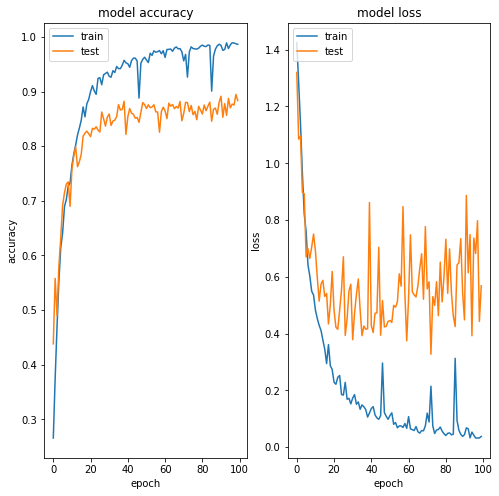

In [112]:
plot_learning_curve(history.history)
plt.show()